In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score

df_fake_news = pd.read_csv("Fake.csv")
df_true_news = pd.read_csv("True.csv")

In [48]:
df_fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [49]:
df_fake_news["subject"].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

In [50]:
#Create a label called category that determines whether a news is fake or not
df_fake_news["category"]=0
df_true_news["category"]=1

#Combine both dataset
df = pd.concat([df_fake_news, df_true_news]).reset_index(drop=True)
df["category"].value_counts()

category
0    23481
1    21417
Name: count, dtype: int64

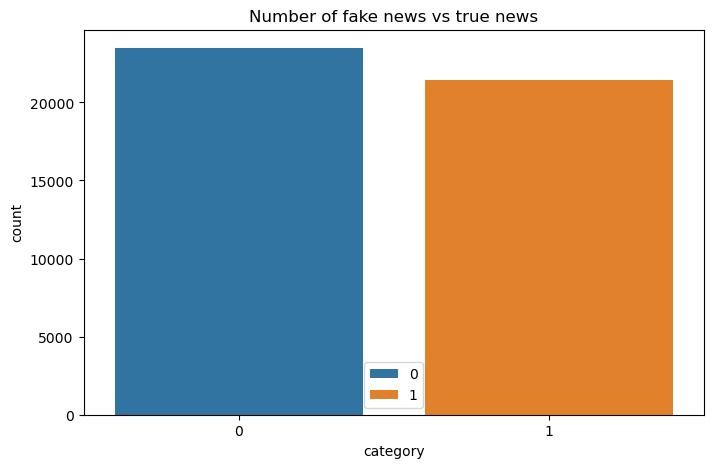

In [51]:
#setting the figure size
plt.figure(figsize=(8,5))
plt.title("Number of fake news vs true news")
sns.countplot(x="category", data=df, hue="category")
plt.legend()

In [52]:
df = df[["text","category"]]
df.tail()

,text,category
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,1
44897,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,1


<h1>#Clean the data </h1>

In [53]:
#Check for columns with null value
df.isnull().sum()*100/(len(df))

text        0.0
category    0.0
dtype: float64

In [54]:
#number of rows before removing rows with empty string
df.shape

(44898, 2)

In [55]:
#Remove rows whose text columns is empty string ""  
df = df[df['text'].str.strip() != '']
df.shape

(44267, 2)

In [56]:
#combine both spacy and nltk
stopwords_combined = set((set(nlp.Defaults.stop_words)| set(stopwords.words("english"))))
lemma = WordNetLemmatizer()

#text cleaning function
def sanitize_text(text):
    
    string = ""
    
    #lower casing
    text=text.lower()
        
    #simplifying text
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"he's","he is",text)
    text=re.sub(r"she's","she is",text)
    text=re.sub(r"that's","that is",text)
    text=re.sub(r"what's","what is",text)
    text=re.sub(r"where's","where is",text)
    text=re.sub(r"\'ll"," will",text)
    text=re.sub(r"\'ve"," have",text)
    text=re.sub(r"\'re"," are",text)
    text=re.sub(r"\'d"," would",text)
    text=re.sub(r"won't","will not",text)
    text=re.sub(r"can't","cannot",text)
    
    #removing any special character
    text=re.sub(r"[-()\"#!@$%^&*{}?.,:]"," ",text)
    text=re.sub(r"\s+"," ",text)
    text=re.sub('[^A-Za-z0-9]+',' ', text)
    
    for word in text.split():
        if word not in stopwords_combined:
            string+=lemma.lemmatize(word)+" "
    
    return string

clean_text = sanitize_text(df["text"][0][:100])
print(clean_text)
print(df["text"][0][:100])

donald trump wish american happy new year leave instead 
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had


In [57]:
df["text"] = df["text"].apply(sanitize_text)
df["text"].head()

0    donald trump wish american happy new year leav...
1    house intelligence committee chairman devin nu...
2    friday revealed milwaukee sheriff david clarke...
3    christmas day donald trump announced work foll...
4    pope francis annual christmas day message rebu...
Name: text, dtype: object

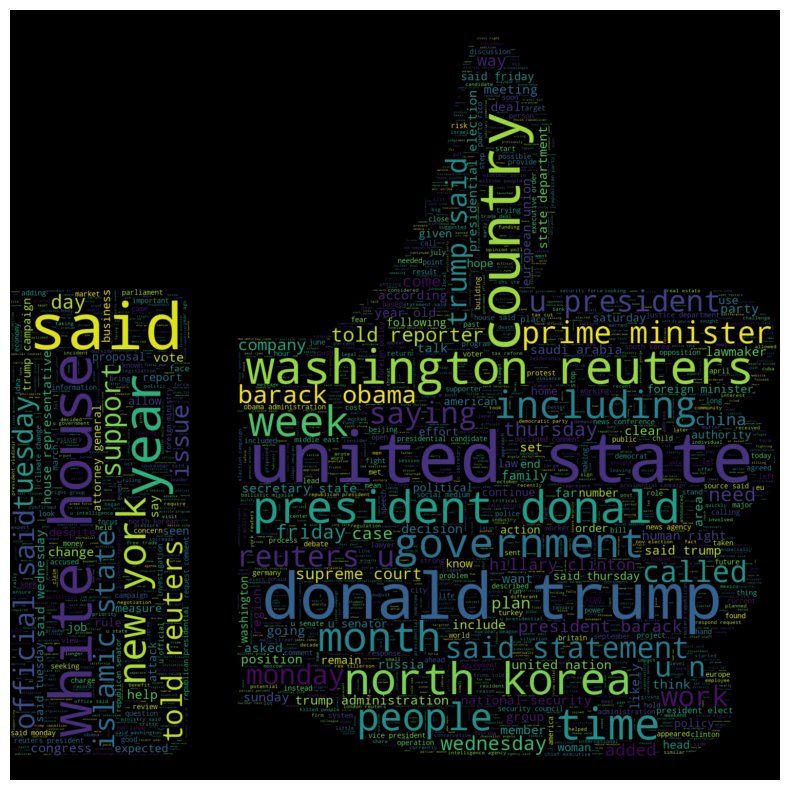

In [58]:
#True News with wordcloud
icon = Image.open("imgs/thumbsup2.png")
mask=Image.new(mode="RGB",size=icon.size, color=(255,255,255))
mask.paste(icon, box=icon)
rgb_array=np.array(mask)

wc = WordCloud(background_color="black", mask=rgb_array, max_words=2000, width=1600, height=800)

# Join and feed text
text_input = " ".join(df[df.category == 1].text)
wc.generate(text_input)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

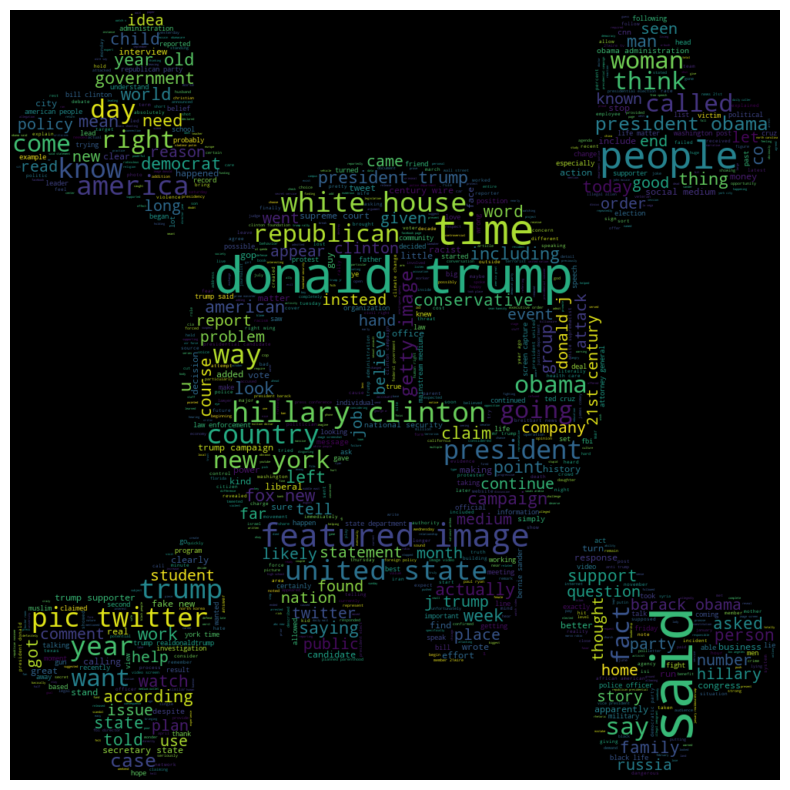

In [59]:
#Fake News

skull_image = "imgs/skull2.png"
icon = Image.open(skull_image)
mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
mask.paste(icon, box=icon)

rgb_array= np.array(mask)

plt.figure(figsize=(10,10))
wc = WordCloud(background_color="black", mask=rgb_array, max_words=2000, width = 1600, 
               height = 800)
wc.generate(" ".join(df[df.category == 0].text))
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

<h1> #Data splitting</h1>

In [60]:
def calculate_percentage(part, total):
    if total == 0:
        return 0
    return (part / total) * 100

x= df["text"] #feature (predictors)
y= df["category"] #labels (target)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(
    f"Predictors size: {x_train.shape[0]} ({calculate_percentage(x_train.shape[0], x.shape[0]):.2f}%) for train, "
    f"{x_test.shape[0]} ({calculate_percentage(x_test.shape[0], x.shape[0]):.2f}%) for test"
)

print(
    f"Target size: {y_train.shape[0]} ({calculate_percentage(y_train.shape[0], y.shape[0]):.2f}%) for train, "
    f"{y_test.shape[0]} ({calculate_percentage(y_test.shape[0], y.shape[0]):.2f}%) for test"
)


Predictors size: 35413 (80.00%) for train, 8854 (20.00%) for test
Target size: 35413 (80.00%) for train, 8854 (20.00%) for test


In [61]:
#TFIDF Vectorizer

vectorizer =TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)


In [62]:
x_train_tfidf

<35413x103008 sparse matrix of type '<class 'numpy.float64'>'
	with 5279881 stored elements in Compressed Sparse Row format>

<h1> #Model Building using LinearSVC</h1>

In [63]:
classifier = LinearSVC(dual=True)
classifier.fit(x_train_tfidf, y_train)

LinearSVC(dual=True)

In [64]:
text_classifier = Pipeline([("tfidf", TfidfVectorizer()), ("clf", LinearSVC(dual=True))])
text_classifier.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC(dual=True))])

<h1>#Model Evaluation</h1>

In [65]:
predictions = text_classifier.predict(x_test)

In [66]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4585
           1       0.99      0.99      0.99      4269

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



In [67]:
print(metrics.accuracy_score(y_test, predictions))

0.9942398915744296


In [68]:
print(metrics.confusion_matrix(y_test, predictions))

[[4558   27]
 [  24 4245]]
